# HW5.

by Handan Cetin | USCID: 6074572947 | github: handancetin

*Note*: I am aware the submission is 3 days late, I was out of town. If possible, I request to use late days policy to not get 10% penalties for my late submission. Thank you!

In [1]:
import os
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import _tree
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

import sklearn.linear_model as skLM
import sklearn.metrics as skM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor 

import warnings
warnings.filterwarnings('ignore') # for plots

## 1. Decision Trees as Interpretable Models

### 1.(a) Download the Accute Inflamations data
Additional Variable Information
* a1	Temperature of patient  { 35C-42C }	
* a2	Occurrence of nausea  { yes, no }	
* a3	Lumbar pain  { yes, no }	
* a4	Urine pushing (continuous need for urination)  { yes, no }	
* a5	Micturition pains  { yes, no }	
* a6	Burning of urethra, itch, swelling of urethra outlet  { yes, no }	
* d1	decision: Inflammation of urinary bladder  { yes, no }	
* d2	decision: Nephritis of renal pelvis origin { yes, no }	

In [2]:
df = pd.read_csv('../data/diagnosis.data', sep = '\s+', header = None, decimal = ',', encoding = 'UTF_16')
colNames = {0: 'Temperature',
            1: 'Nausea',
            2: 'Lumbar Pain',
            3: 'Urine Pushing',
            4: 'Micturition Pains',
            5: 'Burning',
            6: 'Inflammation Decision',
            7: 'Nephritis Decision'}
df = df.rename(columns = colNames)

# Convert to numeric booleans
for col in df.columns :
    df.loc[df[col] == 'no', col] = 0
    df.loc[df[col] == 'yes', col] = 1
df
df

,Temperature,Nausea,Lumbar Pain,Urine Pushing,Micturition Pains,Burning,Inflammation Decision,Nephritis Decision
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1



### 1.(b) Build a decision tree on the whole data set and plot it

In [3]:
# Split the data
trainingFeatures = df.iloc[:, :-2]
trainingTarget = df.iloc[:, 6:].astype('int') 
trainingTarget1 = df.iloc[:, -2:-1].astype('int')
trainingTarget2 = df.iloc[:, -1:].astype('int')

print("------- Size of variables -------")
print("Features \t x \t", trainingFeatures.shape)
print("Target (both) \t y \t", trainingTarget.shape)

print("Target (infl) \t y1 \t", trainingTarget1.shape)
print("Target (neph) \t y2 \t", trainingTarget2.shape)

------- Size of variables -------
Features 	 x 	 (120, 6)
Target (both) 	 y 	 (120, 2)
Target (infl) 	 y1 	 (120, 1)
Target (neph) 	 y2 	 (120, 1)


[Text(0.4, 0.9, 'Temperature <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'Lumbar Pain <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.6, 0.7, 'Lumbar Pain <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'Nausea <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'Urine Pushing <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

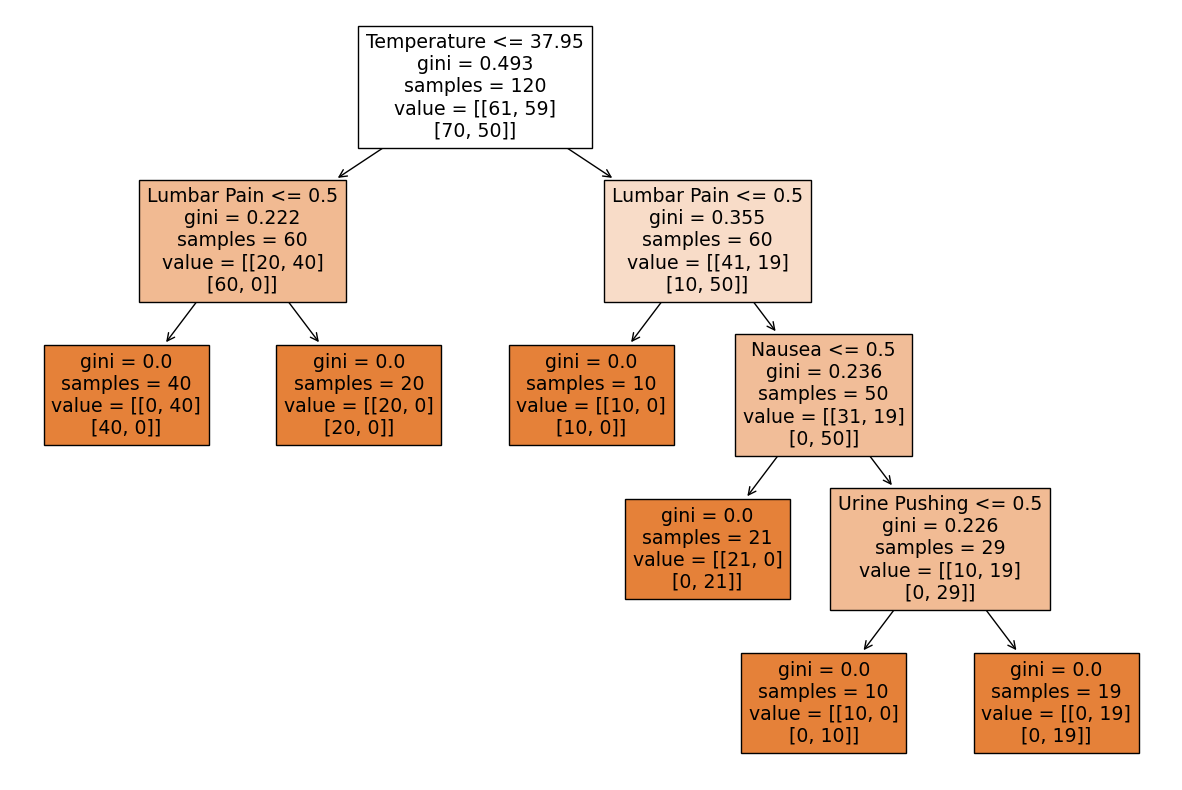

In [4]:
treeClassifier = DecisionTreeClassifier() 
treeClassifier.fit(trainingFeatures, trainingTarget)

fig = plt.figure(figsize = (15, 10))
tree.plot_tree(treeClassifier, filled = True, 
                feature_names = trainingFeatures.columns, 
                class_names   = trainingTarget.columns)

### 1.(c) Convert the decision rules into a set of IF-THEN rules
Source: https://mljar.com/blog/extract-rules-decision-tree/

In [5]:
def getTreeRules(tree, features):
    tree_ = tree.tree_
    feature_name = [ features[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    print("def tree({}):".format(", ".join(features)))

    def recursion(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold}:")
            recursion(tree_.children_left[node], depth + 1)
            print(f"{indent}else:  # if {name} > {threshold}")
            recursion(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return {tree_.value[node]}")

    recursion(0, 1)


In [6]:
# Use the classifier defined in the previous cell
getTreeRules(treeClassifier, trainingFeatures.columns)

def tree(Temperature, Nausea, Lumbar Pain, Urine Pushing, Micturition Pains, Burning):
  if Temperature <= 37.95000076293945:
    if Lumbar Pain <= 0.5:
      return [[ 0. 40.]
 [40.  0.]]
    else:  # if Lumbar Pain > 0.5
      return [[20.  0.]
 [20.  0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar Pain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if Lumbar Pain > 0.5
      if Nausea <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Nausea > 0.5
        if Urine Pushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if Urine Pushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### 1.(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability

Text(0, 0.5, 'impurity of leaves')

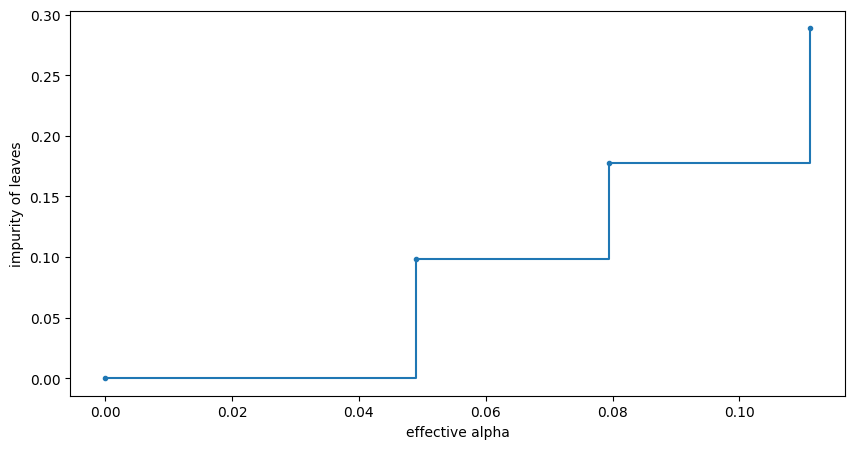

In [7]:
# Get cost-complexity pruning path
pruningPath = treeClassifier.cost_complexity_pruning_path(trainingFeatures, trainingTarget)
ccp_alphas = pruningPath['ccp_alphas']
impurities = pruningPath['impurities']

fig, axes = plt.subplots(figsize = (10, 5))
axes.plot(ccp_alphas[:-1], impurities[:-1], marker = '.', drawstyle = 'steps-post')
axes.set_xlabel("effective alpha")
axes.set_ylabel("impurity of leaves")

In [8]:
parameters = {'ccp_alpha': ccp_alphas}
gridSearch = GridSearchCV(DecisionTreeClassifier(), parameters)
gridSearch.fit(trainingFeatures, trainingTarget)
gridSearch.cv_results_

{'mean_fit_time': array([0.0025423 , 0.00206246, 0.0020772 , 0.0017971 , 0.00183325]),
 'std_fit_time': array([3.75222139e-04, 1.84191622e-04, 4.07944475e-04, 9.57214936e-05,
        1.47932025e-04]),
 'mean_score_time': array([0.00231686, 0.00226784, 0.00182796, 0.00181017, 0.00173535]),
 'std_score_time': array([3.89084851e-04, 1.89318584e-04, 7.90319291e-05, 1.51547416e-04,
        3.87987250e-05]),
 'param_ccp_alpha': masked_array(data=[0.0, 0.04908333333333333, 0.07947222222222226,
                    0.1111111111111111, 0.204236111111111],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ccp_alpha': 0.0},
  {'ccp_alpha': 0.04908333333333333},
  {'ccp_alpha': 0.07947222222222226},
  {'ccp_alpha': 0.1111111111111111},
  {'ccp_alpha': 0.204236111111111}],
 'split0_test_score': array([1.        , 1.        , 1.        , 0.54166667, 0.54166667]),
 'split1_test_score': array([1.  , 1.  , 1.  , 0.75, 0.  ]),
 'spli

In [9]:
print('Best score:', round(gridSearch.best_score_, 4))
print('Best alpha:', gridSearch.best_params_)

Best score: 0.95
Best alpha: {'ccp_alpha': 0.0}


[Text(0.4, 0.9, 'Temperature <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'Lumbar Pain <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.6, 0.7, 'Lumbar Pain <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'Nausea <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'Urine Pushing <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

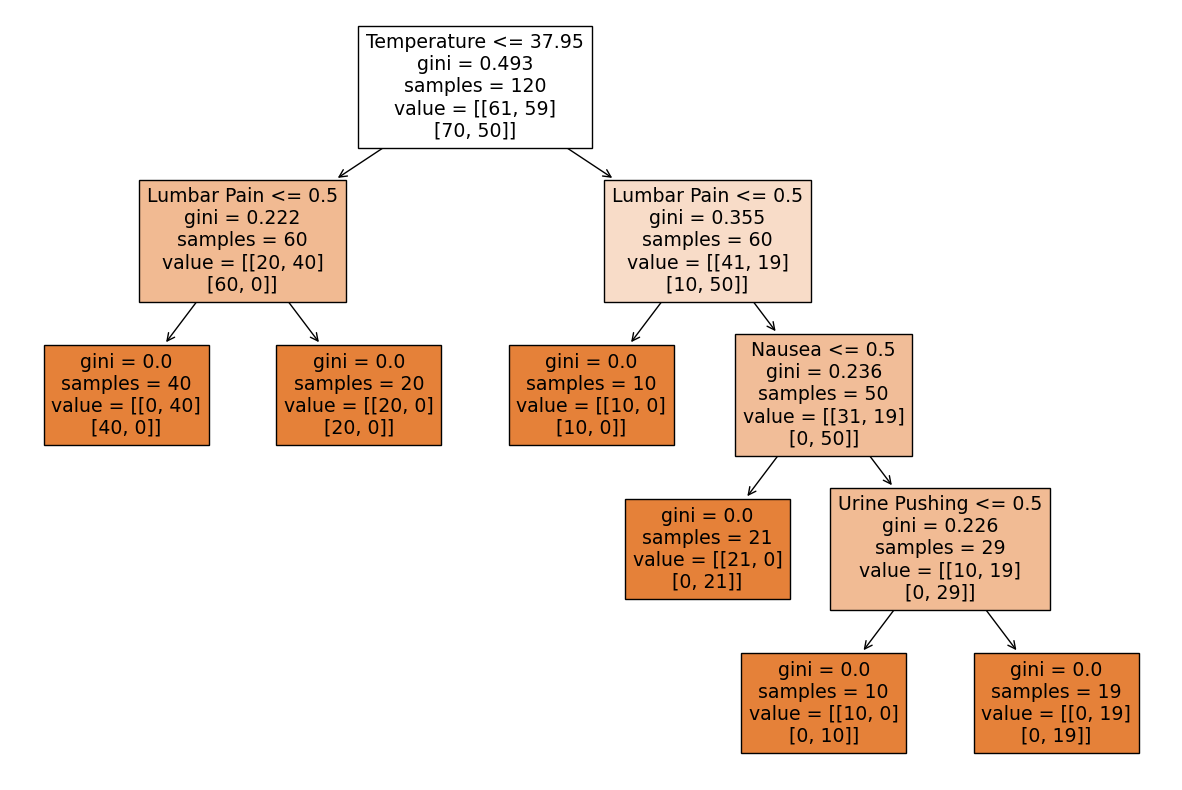

In [10]:
prunedTreeClassifier = DecisionTreeClassifier(ccp_alpha = gridSearch.best_params_['ccp_alpha'])
prunedTreeClassifier.fit(trainingFeatures, trainingTarget)

fig = plt.figure(figsize = (15, 10))
tree.plot_tree(prunedTreeClassifier, filled = True, 
                feature_names = trainingFeatures.columns, 
                class_names   = trainingTarget.columns)

In [11]:
getTreeRules(prunedTreeClassifier, trainingFeatures.columns)

def tree(Temperature, Nausea, Lumbar Pain, Urine Pushing, Micturition Pains, Burning):
  if Temperature <= 37.95000076293945:
    if Lumbar Pain <= 0.5:
      return [[ 0. 40.]
 [40.  0.]]
    else:  # if Lumbar Pain > 0.5
      return [[20.  0.]
 [20.  0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar Pain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if Lumbar Pain > 0.5
      if Nausea <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Nausea > 0.5
        if Urine Pushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if Urine Pushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


Minimal decision tree is the same as the original decision tree.

## 2. The LASSO and Boosting for Regression

### 2.(a) Download the Communities and Crime data
from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

Use the first 1495 rows of data as the training set and the rest as the test set.

In [12]:
colnames = []
with open('../data/communities.names') as f:
    for line in f:
        if '@attribute' in line:
            colnames.append(line.split()[1])

commsdf = pd.read_csv('../data/communities.data', header = None, names = colnames)
commsdf

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### 2.(a) Use a data imputation technique to deal with the missing values in the data set. 
The data description mentions some features are nonpredictive. Ignore those features.

In [13]:
# Replace ? with NaNs
def replaceMissings(x):
    if x == '?':
        return np.nan
    else :
        return x
    
for col in commsdf.columns:
    commsdf[col]=commsdf[col].apply(lambda x: replaceMissings(x))

# Use mean values instead 
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
commsdf.iloc[:, 5:] = imputer.fit_transform(commsdf.iloc[:, 5:]) # skip descriptive cols

# Ignore descriptive columns
data = commsdf.iloc[:, 5:]
data

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


### 2.(c) Plot a correlation matrix for the features in the data set

In [14]:
corr = data.corr()
corr.style.background_gradient(cmap = 'coolwarm')

### 2.(d) Calculate the Coefficient of Variation CV for each feature
where CV = s/m, in which s is sample standard deviation and m is sample mean.

In [15]:
# Loop through data to calculate cv = s/m
coeffvars = data.iloc[:,:-1].apply(lambda x: np.std(x, ddof = 1) / np.mean(x) * 100 )
for col in coeffvars.index:
    print(col,'\t =', round(coeffvars[col], 4))

population 	 = 220.3503
householdsize 	 = 35.3298
racepctblack 	 = 141.092
racePctWhite 	 = 32.3782
racePctAsian 	 = 135.9162
racePctHisp 	 = 161.4278
agePct12t21 	 = 36.584
agePct12t29 	 = 29.0693
agePct16t24 	 = 49.5161
agePct65up 	 = 42.3442
numbUrban 	 = 200.1744
pctUrban 	 = 63.8849
medIncome 	 = 57.9753
pctWWage 	 = 32.771
pctWFarmSelf 	 = 70.003
pctWInvInc 	 = 35.924
pctWSocSec 	 = 36.8513
pctWPubAsst 	 = 69.9031
pctWRetire 	 = 34.9639
medFamInc 	 = 52.7732
perCapInc 	 = 54.5633
whitePerCap 	 = 50.7552
blackPerCap 	 = 58.9469
indianPerCap 	 = 80.9685
AsianPerCap 	 = 60.6194
OtherPerCap 	 = 67.0645
HispPerCap 	 = 47.396
NumUnderPov 	 = 230.497
PctPopUnderPov 	 = 75.398
PctLess9thGrade 	 = 67.56
PctNotHSGrad 	 = 52.8286
PctBSorMore 	 = 57.8401
PctUnemployed 	 = 55.6133
PctEmploy 	 = 34.7327
PctEmplManu 	 = 51.058
PctEmplProfServ 	 = 39.8226
PctOccupManu 	 = 50.8461
PctOccupMgmtProf 	 = 42.2106
MalePctDivorce 	 = 39.5583
MalePctNevMarr 	 = 40.3812
FemalePctDiv 	 = 35.9273
TotalPctD

### 2.(e) Pick floor(√128) features with highest CV, and make scatter plots and box plots 
Can you draw conclusions about significance of those features, just by the scatter plots?

In [16]:
# Sort the features by CVs and pick top floor(√128c)
sortedCoeffvars = coeffvars.sort_values(ascending = False)
topCoeffvars = sortedCoeffvars.index[0:np.floor(128 ** 0.5).astype(int)]
topCoeffvars

Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')

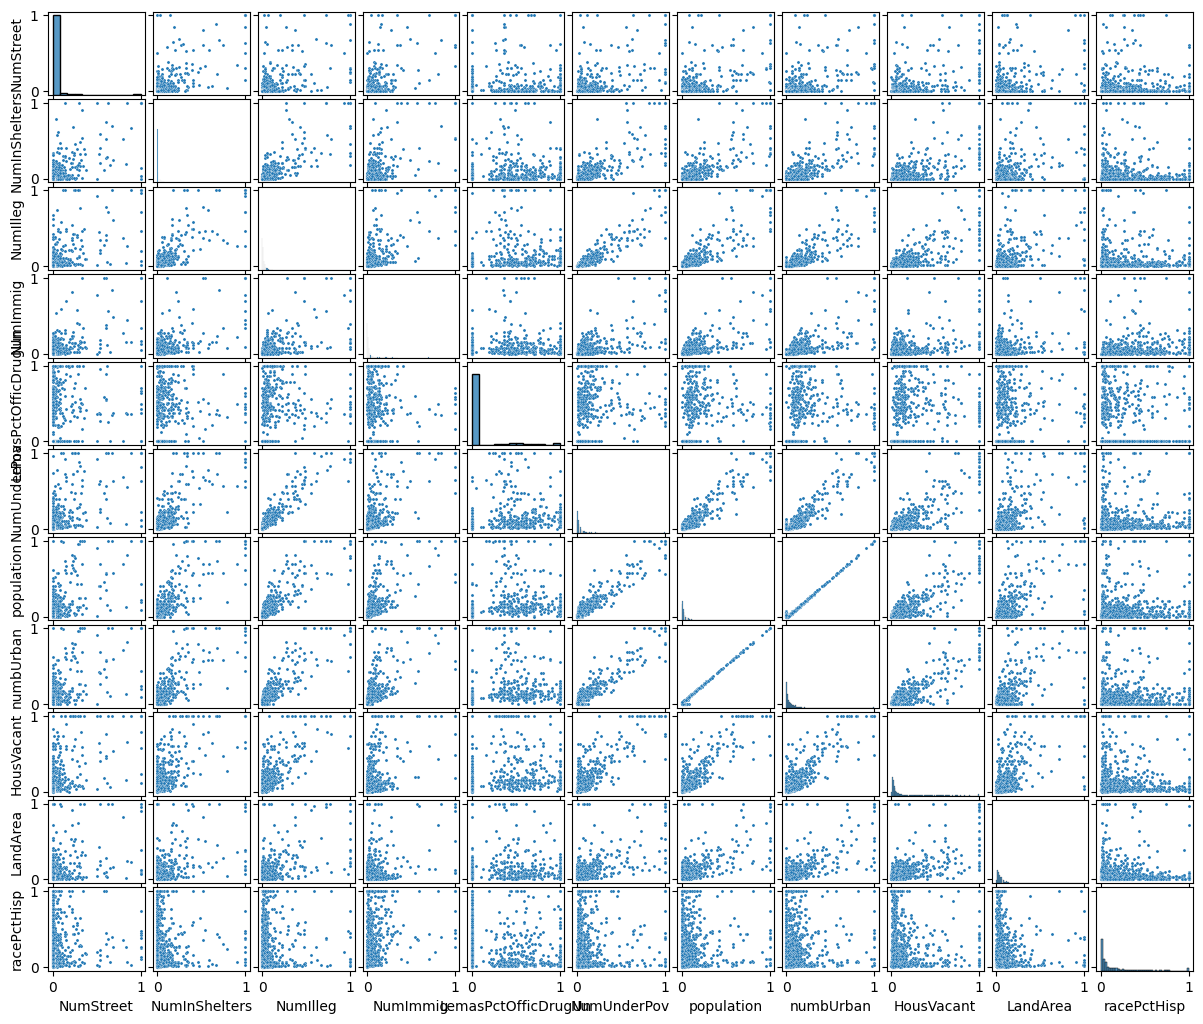

In [17]:
# Scatter plots 
p = sns.pairplot(data = data[topCoeffvars], kind = 'scatter',  grid_kws={'despine' : False}, plot_kws={"s": 5})
p.fig.set_size_inches(12,10)

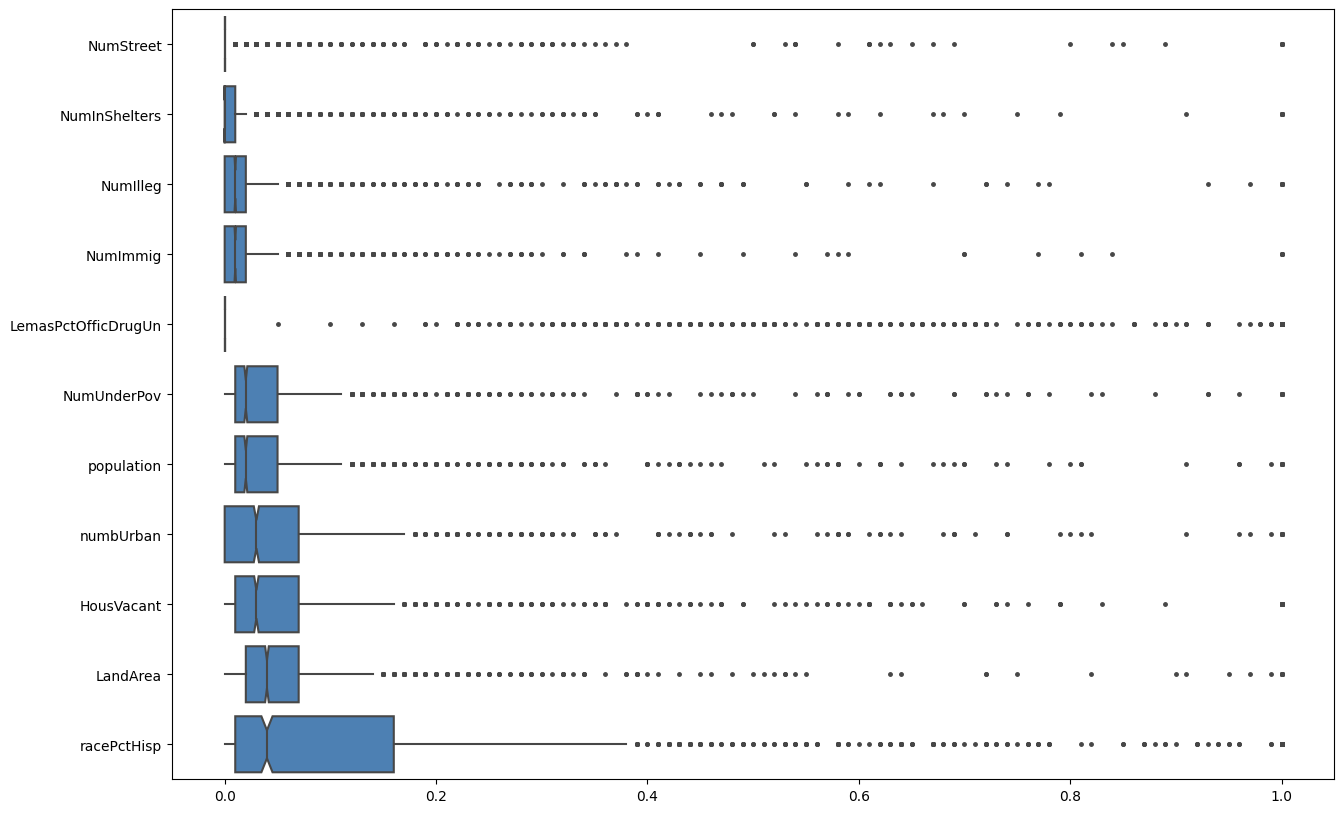

In [18]:
# Box plots
fig = plt.figure(figsize = (15, 10))
p = sns.boxplot(data = data[topCoeffvars], notch=True, showcaps = False, orient="h",
                flierprops = {"marker": "."}, boxprops = {"facecolor": (.3, .5, .7)})

Looking at the plots, all we can say that population and numbUrban features are highly correlated with each other. However, we cannot conclude any *significance* just by looking at these plots, we need to test statistically.

###  Split data according to 2(a)

In [19]:
features, target = data.iloc[:,:-1], data['ViolentCrimesPerPop']
trainingFeatures, testingFeatures = features[:1495], features[1495:]
trainingTarget, testingTarget     = target[:1495],   target[1495:]

### 2.(f) Fit a linear model using least squares to the training set and report the test error.

In [20]:
# Linear regression
modelReg = skLM.LinearRegression().fit(trainingFeatures, trainingTarget)
testingPredicted = modelReg.predict(testingFeatures)
print('Test Error =', round(skM.mean_squared_error(testingTarget, testingPredicted), 4))

Test Error = 0.7897


### 2.(g) Fit a ridge regression model on the training set with λ chosen by CV, report the test error.

In [21]:
# Ridge regression 
modelRidge = skLM.RidgeCV().fit(trainingFeatures, trainingTarget)
testingPredicted = modelRidge.predict(testingFeatures) 
print('Test Error =', round(skM.mean_squared_error(testingTarget, testingPredicted), 4))

Test Error = 0.0177


### 2.(h) Fit a LASSO model on the training set, with λ chosen by CV, report the test error
along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [22]:
# Regression with LASSO
modelLasso = skLM.LassoCV(max_iter=1500).fit(trainingFeatures, trainingTarget)
testingPredicted = modelLasso.predict(testingFeatures) 
print('Test Error =', round(skM.mean_squared_error(testingTarget, testingPredicted), 5))

print('\n-- List of Variables --')
for i in range(0,len(testingFeatures.columns)):
    if modelLasso.coef_[i]!=0:
        print(testingFeatures.columns[i],'\t =', round(modelLasso.coef_[i], 4))

Test Error = 0.01776

-- List of Variables --
racepctblack 	 = 0.272
racePctAsian 	 = -0.0155
agePct12t21 	 = 0.0663
agePct12t29 	 = -0.265
pctUrban 	 = 0.0405
pctWWage 	 = -0.0847
pctWFarmSelf 	 = 0.0266
pctWInvInc 	 = -0.0983
pctWSocSec 	 = 0.0486
pctWPubAsst 	 = 0.0388
pctWRetire 	 = -0.1084
whitePerCap 	 = -0.0577
blackPerCap 	 = -0.0211
indianPerCap 	 = -0.0311
AsianPerCap 	 = 0.029
OtherPerCap 	 = 0.0227
HispPerCap 	 = 0.0239
PctPopUnderPov 	 = -0.1412
PctLess9thGrade 	 = -0.0182
PctEmploy 	 = 0.1373
PctEmplManu 	 = -0.0158
PctOccupManu 	 = 0.0102
MalePctDivorce 	 = 0.1181
MalePctNevMarr 	 = 0.1333
FemalePctDiv 	 = -0.0785
PctKids2Par 	 = -0.1965
PctYoungKids2Par 	 = -0.0378
PctTeen2Par 	 = -0.0102
PctWorkMom 	 = -0.1295
NumIlleg 	 = -0.0574
PctIlleg 	 = 0.0984
NumImmig 	 = -0.0699
PctImmigRec10 	 = -0.0051
PctRecImmig10 	 = 0.0375
PctNotSpeakEnglWell 	 = -0.0711
PctLargHouseOccup 	 = -0.065
PersPerOccupHous 	 = 0.0423
PctPersOwnOccup 	 = -0.0573
PctPersDenseHous 	 = 0.2192
PctHo

In [23]:
# LASSO with standartized features
modelLassoStd = skLM.LassoCV(max_iter = 1500) 
standardizer = StandardScaler()
modelLassoStd.fit(standardizer.fit_transform(trainingFeatures), trainingTarget)

testingPredicted = modelLassoStd.predict(standardizer.transform(testingFeatures)) 
print('Test Error =', round(skM.mean_squared_error(testingTarget, testingPredicted), 5))

print('\n-- List of Variables --')
for i in range(0,len(testingFeatures.columns)):
    if modelLassoStd.coef_[i]!=0:
        print(testingFeatures.columns[i],'\t =', round(modelLassoStd.coef_[i], 4))

Test Error = 0.01781

-- List of Variables --
racepctblack 	 = 0.0683
racePctAsian 	 = -0.0009
agePct12t21 	 = 0.0103
agePct12t29 	 = -0.0382
pctUrban 	 = 0.0166
pctWWage 	 = -0.012
pctWFarmSelf 	 = 0.0041
pctWInvInc 	 = -0.0208
pctWSocSec 	 = 0.0089
pctWPubAsst 	 = 0.0061
pctWRetire 	 = -0.0172
whitePerCap 	 = -0.0086
blackPerCap 	 = -0.0036
indianPerCap 	 = -0.0052
AsianPerCap 	 = 0.0053
OtherPerCap 	 = 0.0038
HispPerCap 	 = 0.004
PctPopUnderPov 	 = -0.0268
PctLess9thGrade 	 = -0.002
PctEmploy 	 = 0.0212
PctEmplManu 	 = -0.0011
MalePctDivorce 	 = 0.019
MalePctNevMarr 	 = 0.0207
FemalePctDiv 	 = -0.01
PctKids2Par 	 = -0.0398
PctYoungKids2Par 	 = -0.0082
PctTeen2Par 	 = -0.0015
PctWorkMom 	 = -0.0214
NumIlleg 	 = -0.0046
PctIlleg 	 = 0.0247
NumImmig 	 = -0.0082
PctImmigRec5 	 = -0.0001
PctImmigRec10 	 = -0.0006
PctRecImmig10 	 = 0.0066
PctNotSpeakEnglWell 	 = -0.009
PctLargHouseOccup 	 = -0.007
PersPerOccupHous 	 = 0.0037
PctPersOwnOccup 	 = -0.0093
PctPersDenseHous 	 = 0.0406
PctHousL

Testing errors for LASSO models are quite similar, there is only 0.00005 increase after standardizing the features.

### 2.(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by CV. 
Report the test error obtained

In [24]:
# Principal component regression - Find best M value
bestM = 1
bestScore = 0
linreg = skLM.LinearRegression()
for i in range(1, 120):
    pca = PCA(n_components = i)
    pipeline = Pipeline(steps = [('pca', pca), ('lr', linreg)])
    scores = cross_val_score(pipeline, trainingFeatures, trainingTarget, cv=5)
    if bestScore < scores.mean():
        bestM = i
        bestScore = scores.mean()

print('Best M value is', bestM,'with score', round(bestScore, 4))

Best M value is 96 with score 0.6567


In [25]:
# Principal component regression with 96 components
standardizer = StandardScaler()
pca = PCA(n_components = bestM)
pipeline = Pipeline(steps = [('pca', pca), ('scaler', standardizer), ('lr', linreg)])
pipeline.fit(trainingFeatures, trainingTarget)

testingPredicted = pipeline.predict(testingFeatures)
print('Test Error =', round(skM.mean_squared_error(testingTarget, testingPredicted), 5))

Test Error = 0.01848


### 2.(j) In this section, we would like to fit a boosting tree to the data. 
As in classification trees, one can use any type of regression at each node to build a multivariate
regression tree. Because the number of variables is large in this problem, one
can use L1-penalized regression at each node. Such a tree is called L1 penalized
gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine
α (the regularization term) using cross-validation

In [26]:
# Gradient Boosting regression - Find best alpha
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 100, 1000]}
gridSearch = GridSearchCV(GradientBoostingRegressor(), param_grid = parameters, cv = 5, scoring = 'neg_mean_squared_error')
gridSearch.fit(trainingFeatures, trainingTarget)
print('Best alpha is found at', gridSearch.best_params_['alpha'], 'with score', round(-gridSearch.best_score_, 4))

Best alpha is found at 0.1 with score 0.0207


In [27]:
# Gradient Boosting regression with alpha = 0.1
modelGBR = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, alpha = gridSearch.best_params_['alpha'])
modelGBR.fit(trainingFeatures, trainingTarget)

testingPredicted = modelGBR.predict(testingFeatures)
print('Test Error =', round(skM.mean_squared_error(testingTarget, testingPredicted), 4))

Test Error = 0.0167
